In [26]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import wget

In [2]:
# Download the csv file and save inside the main folder of the repository
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv'
#wget.download(url, 'data/bbc.csv')

In [3]:
# Stop words taken from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and",
             "any", "are", "as", "at", "be", "because", "been", "before", "being", "below",
             "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down",
             "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him",
             "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in",
             "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my",
             "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours",
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's",
             "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
             "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll",
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's",
             "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why",
             "why's", "with", "would", "you","you'd", "you'll", "you're", "you've", "your", "yours",
             "yourself", "yourselves" ]

In [4]:
# iterate through the csv file, and separate the entries into labels and text
text = []
labels = []
with open('data/bbc.csv') as csvfile:
    rawdata = csv.reader(csvfile, delimiter=",")
    next(rawdata)
    for row in rawdata:
        labels.append(row[0])
        article = row[1]
        for word in stopwords:
            # separate out each word explicitly to prevent removing these parts of non stop words
            drop_stop_words = " " + word + " "
            article = article.replace(drop_stop_words, " ")
            article = article.replace("  "," ")
        text.append(article)

In [5]:
# verify lists were created properly
print(len(text))
print(len(labels))
print(text[0])

2225
2225
tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend programmes content will delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us s tivo uk s sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take off europe lack high-definition programming. not can people forward wind adverts can also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cab

In [97]:
# standardize dimensions that will be used to tokenize the text and create sequences
vocabulary_size = 20000
embedding_dimension = 16
max_length = 800
truncation_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8
split_size = int(len(text) * training_portion)

In [98]:
# split the data into training and validation sets
training_text = text[0:split_size]
training_labels = labels[0:split_size]

validation_text = text[split_size:]
validation_labels = labels[split_size:]

#verify split worked as intended
print(split_size)
print(len(training_text))
print(len(training_labels))
print(len(validation_text))
print(len(validation_labels))

1780
1780
1780
445
445


In [99]:
# using tensorflow, create an index of words used in the training data
tokenizer = Tokenizer(num_words = vocabulary_size,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(training_text)
word_list = tokenizer.word_index
print(len(word_list))

27285


In [100]:
# convert each article into a standard length numeric sequence 
training_sequences = tokenizer.texts_to_sequences(training_text)
padded_training = pad_sequences(training_sequences,
                               maxlen = max_length,
                               truncating = truncation_type)

validation_sequences = tokenizer.texts_to_sequences(validation_text)
padded_validation = pad_sequences(validation_sequences,
                               maxlen = max_length,
                               truncating = truncation_type)

print(padded_training.shape)
print(padded_validation.shape)

(1780, 800)
(445, 800)


In [101]:
# convert labels into numbers
tokenize_labels = Tokenizer()
tokenize_labels.fit_on_texts(labels)

labels_index = tokenize_labels.word_index
print(labels_index)
numeric_training_labels = np.array(tokenize_labels.texts_to_sequences(training_labels))
numeric_validation_labels = np.array(tokenize_labels.texts_to_sequences(validation_labels))

print(numeric_training_labels[0:5])
print(numeric_training_labels.shape)
print(numeric_validation_labels[0:5])
print(numeric_validation_labels.shape)

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
[[4]
 [2]
 [1]
 [1]
 [5]]
(1780, 1)
[[5]
 [4]
 [3]
 [1]
 [1]]
(445, 1)


In [102]:
# Training model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation ='relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = RMSprop(learning_rate=0.08),
              metrics = ['accuracy'])

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 800, 16)           320000    
_________________________________________________________________
global_average_pooling1d_24  (None, 16)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 198       
Total params: 320,742
Trainable params: 320,742
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Training execution
number_epochs = 30
history = model.fit(padded_training, numeric_training_labels,
                    validation_data = (padded_validation, numeric_validation_labels),
                    epochs = number_epochs, batch_size=1780)

Epoch 1/30
1/1 [==============================] - 1s 568ms/step - loss: 1.7946 - accuracy: 5.6180e-04 - val_loss: 1.7112 - val_accuracy: 0.2966
Epoch 2/30
1/1 [==============================] - 0s 130ms/step - loss: 1.6965 - accuracy: 0.3213 - val_loss: 4.1510 - val_accuracy: 0.2382
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 4.0431 - accuracy: 0.2270 - val_loss: 1.7167 - val_accuracy: 0.2404
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.6418 - accuracy: 0.2601 - val_loss: 1.5686 - val_accuracy: 0.1955
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5452 - accuracy: 0.2011 - val_loss: 1.4949 - val_accuracy: 0.1978
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 1.4625 - accuracy: 0.2011 - val_loss: 1.5038 - val_accuracy: 0.2921
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 1.3579 - accuracy: 0.3685 - val_loss: 2.2945 - val_accuracy: 0.2449
Epoch 8/30
1/1 [

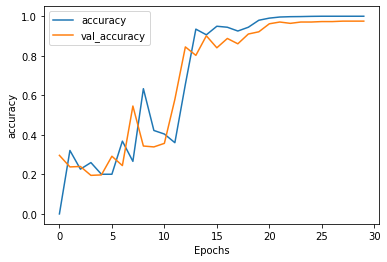

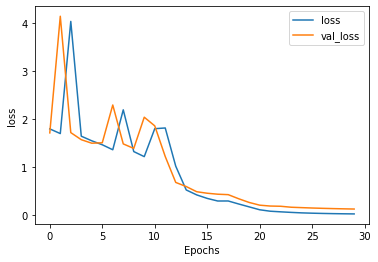

In [104]:
# This code taken directly from "Laurence Mahoney, Course 3 - Week 2 - Exercise"
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")